# DATA

In [179]:
import os
import random

batch_size = 512

def create_dataset(path):
    dataset = []
    for root, dirs, files in os.walk(path):
        for file in files:
            name = file.split("__")[1]
            if "_" not in name and "f" not in name and "r" not in name:
                file = file.split(".")[0]
                for i in range(10):
                    input1 = root + "/" + file + ".png"
                    input2 = root + "/" + file + "_" + str(i) + ".png"
                    GT = root + "/" + file + "_" + str(i) + "_GT.png"
                    dataset.append((input1, input2, GT))
            elif ("_flip_" in name or "_rot_" in name) and "GT" not in name:
                file = file.split(".")[0]
                if file[-1] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]:
                    continue
                for i in range(10):
                    input1 = root + "/" + file + ".png"
                    input2 = root + "/" + file + "_" + str(i) + ".png"
                    GT = root + "/" + file + "_" + str(i) + "_GT.png"
                    dataset.append((input1, input2, GT))
    return dataset

train = create_dataset("train")
test = create_dataset("test")
validation = create_dataset("validation")

x_train = []
y_train = []
x_test = []
y_test = []
x_validation = []
y_validation = []

for i in range(0, len(train), 8): #TODO:
    x_train.append((train[i][0], train[i][1]))
    y_train.append(train[i][2])

for i in range(len(test)):
    x_test.append((test[i][0], test[i][1]))
    y_test.append(test[i][2])

for i in range(0, len(validation), 8):
    x_validation.append((validation[i][0], validation[i][1]))
    y_validation.append(validation[i][2])

def get_batch(x, y, batch_size):
    # shuffle x and y
    zipped = list(zip(x, y))
    random.shuffle(zipped)
    x, y = zip(*zipped)
    batch = []
    for i in range(batch_size):
        batch.append((x[i], y[i]))
    return batch

def get_non_random_batch(x, y, batch_size, start_index):
    batch = []
    for i in range(batch_size):
        batch.append((x[start_index + i], y[start_index + i]))
    return batch

# Models

In [180]:
# Evaluate on 64x64 images
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2DBlock_ppm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2DBlock_ppm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResNetBlock_ppm(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock_ppm, self).__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x):
        return x + self.block(x)

class DownsampleBlock_ppm(nn.Module):
    def __init__(self, channels):
        super(DownsampleBlock_ppm, self).__init__()
        self.downsample = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return self.downsample(x)

class UpsampleBlock_ppm(nn.Module):
    def __init__(self, channels):
        super(UpsampleBlock_ppm, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        return self.upsample(x)

class TransformerBlock_ppm(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock_ppm, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ff = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(inplace=True),
            nn.Linear(embed_size * 4, embed_size)
        )
        self.norm2 = nn.LayerNorm(embed_size)
        
    def forward(self, x):
        #x = x.permute(2, 0, 1)  # (B, H*W, C) -> (H*W, B, C)
        x_cal = self.norm1(x)
        # multi head selfattention with 4 heads
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        #do it again
        x_cal = self.norm1(x)
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        # layer normalization
        x_cal = self.norm2(x)
        # feed forward network
        x_cal = self.ff(x_cal)
        return x + x_cal

class Encoder_ppm(nn.Module):
    def __init__(self):
        super(Encoder_ppm, self).__init__()
        self.initial_conv = Conv2DBlock_ppm(2, 64, kernel_size=5, stride=1, padding=2)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_ppm(64),
                DownsampleBlock_ppm(64)
            ) for _ in range(3)
        ])

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        b, c, h, w = x.size()
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, c, x.device)
        
        x = x.flatten(2).permute(2, 0, 1)  # (B, C, H, W) -> (H*W, B, C)
        x = x + positional_embeddings
        return x, h, w
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(height * width, 1, channels, device=device)
        return pos_embed

class Decoder_ppm(nn.Module):
    def __init__(self):
        super(Decoder_ppm, self).__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_ppm(64),
                UpsampleBlock_ppm(64)
            ) for _ in range(3)
        ])
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, h, w):
        x = x.permute(1, 2, 0).view(-1, 64, h, w)  # (H*W, B, C) -> (B, C, H, W)
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, 64, x.device)
        
        x = x + positional_embeddings
        for block in self.blocks:
            x = block(x)
        x = self.tanh(self.final_conv(x))
        return x
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(1, channels, height, width, device=device)
        return pos_embed

class PPMModel_ppm(nn.Module):
    def __init__(self):
        super(PPMModel_ppm, self).__init__()
        self.encoder = Encoder_ppm()
        self.transformer_blocks = nn.ModuleList([TransformerBlock_ppm(64, 8) for _ in range(4)])
        self.decoder = Decoder_ppm()
        
    def forward(self, x):
        x, h, w = self.encoder(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = self.decoder(x, h, w)
        return x



class Conv2DBlock_cf(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2DBlock_cf, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResNetBlock_cf(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock_cf, self).__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x):
        return x + self.block(x)

class DownsampleBlock_cf(nn.Module):
    def __init__(self, channels):
        super(DownsampleBlock_cf, self).__init__()
        self.downsample = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return self.downsample(x)

class UpsampleBlock_cf(nn.Module):
    def __init__(self, channels):
        super(UpsampleBlock_cf, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        return self.upsample(x)

class TransformerBlock_cf(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock_cf, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ff = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(inplace=True),
            nn.Linear(embed_size * 4, embed_size)
        )
        self.norm2 = nn.LayerNorm(embed_size)
        
    def forward(self, x):
        #x = x.permute(2, 0, 1)  # (B, H*W, C) -> (H*W, B, C)
        x_cal = self.norm1(x)
        # multi head selfattention with 4 heads
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        #do it again
        x_cal = self.norm1(x)
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        # layer normalization
        x_cal = self.norm2(x)
        # feed forward network
        x_cal = self.ff(x_cal)
        return x + x_cal

class Encoder_cf(nn.Module):
    def __init__(self):
        super(Encoder_cf, self).__init__()
        self.initial_conv = Conv2DBlock_cf(2, 64, kernel_size=5, stride=1, padding=2)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_cf(64),
                DownsampleBlock_cf(64)
            ) for _ in range(3)
        ])

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        b, c, h, w = x.size()
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, c, x.device)
        
        x = x.flatten(2).permute(2, 0, 1)  # (B, C, H, W) -> (H*W, B, C)
        x = x + positional_embeddings
        return x, h, w
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(height * width, 1, channels, device=device)
        return pos_embed

class Decoder_cf(nn.Module):
    def __init__(self):
        super(Decoder_cf, self).__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_cf(64),
                UpsampleBlock_cf(64)
            ) for _ in range(3)
        ])
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, h, w):
        x = x.permute(1, 2, 0).view(-1, 64, h, w)  # (H*W, B, C) -> (B, C, H, W)
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, 64, x.device)
        
        x = x + positional_embeddings
        for block in self.blocks:
            x = block(x)
        x = self.tanh(self.final_conv(x))
        return x
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(1, channels, height, width, device=device)
        return pos_embed

class PPMModel_cf(nn.Module):
    def __init__(self):
        super(PPMModel_cf, self).__init__()
        self.encoder = Encoder_cf()
        self.transformer_blocks = nn.ModuleList([TransformerBlock_cf(64, 8) for _ in range(4)])
        self.decoder = Decoder_cf()
        
    def forward(self, x):
        x, h, w = self.encoder(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = self.decoder(x, h, w)
        return x


# For trained on Tiled-MP dataset (3 input channels, but just use 2 in reality)


# Evaluate on 64x64 images
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2DBlock_ppm2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2DBlock_ppm2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResNetBlock_ppm2(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock_ppm2, self).__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x):
        return x + self.block(x)

class DownsampleBlock_ppm2(nn.Module):
    def __init__(self, channels):
        super(DownsampleBlock_ppm2, self).__init__()
        self.downsample = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return self.downsample(x)

class UpsampleBlock_ppm2(nn.Module):
    def __init__(self, channels):
        super(UpsampleBlock_ppm2, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        return self.upsample(x)

class TransformerBlock_ppm2(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock_ppm2, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ff = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(inplace=True),
            nn.Linear(embed_size * 4, embed_size)
        )
        self.norm2 = nn.LayerNorm(embed_size)
        
    def forward(self, x):
        #x = x.permute(2, 0, 1)  # (B, H*W, C) -> (H*W, B, C)
        x_cal = self.norm1(x)
        # multi head selfattention with 4 heads
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        #do it again
        x_cal = self.norm1(x)
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        # layer normalization
        x_cal = self.norm2(x)
        # feed forward network
        x_cal = self.ff(x_cal)
        return x + x_cal

class Encoder_ppm2(nn.Module):
    def __init__(self):
        super(Encoder_ppm2, self).__init__()
        self.initial_conv = Conv2DBlock_ppm2(3, 64, kernel_size=5, stride=1, padding=2)  # only difference here is 3 input channels
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_ppm2(64),
                DownsampleBlock_ppm2(64)
            ) for _ in range(3)
        ])

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        b, c, h, w = x.size()
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, c, x.device)
        
        x = x.flatten(2).permute(2, 0, 1)  # (B, C, H, W) -> (H*W, B, C)
        x = x + positional_embeddings
        return x, h, w
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(height * width, 1, channels, device=device)
        return pos_embed

class Decoder_ppm2(nn.Module):
    def __init__(self):
        super(Decoder_ppm2, self).__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_ppm2(64),
                UpsampleBlock_ppm2(64)
            ) for _ in range(3)
        ])
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, h, w):
        x = x.permute(1, 2, 0).view(-1, 64, h, w)  # (H*W, B, C) -> (B, C, H, W)
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, 64, x.device)
        
        x = x + positional_embeddings
        for block in self.blocks:
            x = block(x)
        x = self.tanh(self.final_conv(x))
        return x
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(1, channels, height, width, device=device)
        return pos_embed

class PPMModel_ppm2(nn.Module):
    def __init__(self):
        super(PPMModel_ppm2, self).__init__()
        self.encoder = Encoder_ppm2()
        self.transformer_blocks = nn.ModuleList([TransformerBlock_ppm2(64, 8) for _ in range(4)])
        self.decoder = Decoder_ppm2()
        
    def forward(self, x):
        x, h, w = self.encoder(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = self.decoder(x, h, w)
        return x



class Conv2DBlock_cf2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2DBlock_cf2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResNetBlock_cf2(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock_cf2, self).__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x):
        return x + self.block(x)

class DownsampleBlock_cf2(nn.Module):
    def __init__(self, channels):
        super(DownsampleBlock_cf2, self).__init__()
        self.downsample = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return self.downsample(x)

class UpsampleBlock_cf2(nn.Module):
    def __init__(self, channels):
        super(UpsampleBlock_cf2, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        return self.upsample(x)

class TransformerBlock_cf2(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock_cf2, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ff = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(inplace=True),
            nn.Linear(embed_size * 4, embed_size)
        )
        self.norm2 = nn.LayerNorm(embed_size)
        
    def forward(self, x):
        #x = x.permute(2, 0, 1)  # (B, H*W, C) -> (H*W, B, C)
        x_cal = self.norm1(x)
        # multi head selfattention with 4 heads
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        #do it again
        x_cal = self.norm1(x)
        x_cal = self.attention(x_cal, x_cal, x_cal)[0]
        x = x + x_cal
        # layer normalization
        x_cal = self.norm2(x)
        # feed forward network
        x_cal = self.ff(x_cal)
        return x + x_cal

class Encoder_cf2(nn.Module):
    def __init__(self):
        super(Encoder_cf2, self).__init__()
        self.initial_conv = Conv2DBlock_cf2(3, 64, kernel_size=5, stride=1, padding=2)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_cf2(64),
                DownsampleBlock_cf2(64)
            ) for _ in range(3)
        ])

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        b, c, h, w = x.size()
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, c, x.device)
        
        x = x.flatten(2).permute(2, 0, 1)  # (B, C, H, W) -> (H*W, B, C)
        x = x + positional_embeddings
        return x, h, w
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(height * width, 1, channels, device=device)
        return pos_embed

class Decoder_cf2(nn.Module):
    def __init__(self):
        super(Decoder_cf2, self).__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                ResNetBlock_cf2(64),
                UpsampleBlock_cf2(64)
            ) for _ in range(3)
        ])
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, h, w):
        x = x.permute(1, 2, 0).view(-1, 64, h, w)  # (H*W, B, C) -> (B, C, H, W)
        
        # Create positional embeddings dynamically based on spatial dimensions
        positional_embeddings = self.get_positional_embeddings(h, w, 64, x.device)
        
        x = x + positional_embeddings
        for block in self.blocks:
            x = block(x)
        x = self.tanh(self.final_conv(x))
        return x
    
    def get_positional_embeddings(self, height, width, channels, device):
        pos_embed = torch.randn(1, channels, height, width, device=device)
        return pos_embed

class PPMModel_cf2(nn.Module):
    def __init__(self):
        super(PPMModel_cf2, self).__init__()
        self.encoder = Encoder_cf2()
        self.transformer_blocks = nn.ModuleList([TransformerBlock_cf2(64, 8) for _ in range(4)])
        self.decoder = Decoder_cf2()
        
    def forward(self, x):
        x, h, w = self.encoder(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = self.decoder(x, h, w)
        return x

# Search and evaluation functions

In [181]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import heapq

# Define the heuristic functions
def manhattan_distance(start, goal):
    return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

def focal_search(w, grid, start, goal, probability_map, cf, cf_map, eps):
    # Initialize the open and closed lists
    open_list = []
    focal_list = []
    closed_list = set()

    # Add the start node to the open list with the priority equal to the heuristic
    heapq.heappush(open_list, (manhattan_distance(start, goal), 0, start))
    focal_list.append((manhattan_distance(start, goal), probability_map[start[0]][start[1]], start))
    
    came_from = {start: None}
    
    g_costs = {start: 0}
    
    while open_list:
        if focal_list:
            focal_list.sort(key=lambda x: x[1], reverse=True)
            current_f, current_g, current = focal_list.pop(0)
            # remove from open list
            open_list = [node for node in open_list if node[2] != current]
            heapq.heapify(open_list)
        else:
            current_f, current_g, current = heapq.heappop(open_list)
        
        closed_list.add(current)
        
        if current == goal:
            path = []
            while current is not None:
                path.append(current)
                current = came_from[current]
            return path[::-1], closed_list
        
        # Update focal list if necessary
        new_focal_list = []
        f_min = open_list[0][0] if open_list else float('inf')
        for node in open_list:
            if node[0] <= eps * f_min:
                new_focal_list.append((node[0], probability_map[node[2][0]][node[2][1]], node[2]))
        focal_list = new_focal_list
        
        # Check the neighbors of the current node
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            
            # Ensure the neighbor is within the grid bounds and is walkable
            if 0 <= neighbor[0] < len(grid) and 0 <= neighbor[1] < len(grid[0]) and grid[neighbor[0]][neighbor[1]] == 1:
                if neighbor in closed_list:
                    continue
                
                # Calculate the tentative g cost
                tentative_g_cost = g_costs[current] + 1
                
                if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                    # Update the cost and path
                    g_costs[neighbor] = tentative_g_cost
                    if cf:
                        if cf_map[neighbor[0]][neighbor[1]] > 0:
                            f_cost = tentative_g_cost + w * manhattan_distance(neighbor, goal) / cf_map[neighbor[0]][neighbor[1]]
                        else:
                            cf_map[neighbor[0]][neighbor[1]] = 0.001
                            f_cost = tentative_g_cost + w * manhattan_distance(neighbor, goal) / cf_map[neighbor[0]][neighbor[1]]
                    else:
                        f_cost = tentative_g_cost + w * manhattan_distance(neighbor, goal)
                    heapq.heappush(open_list, (f_cost, tentative_g_cost, neighbor))
                    if f_cost <= eps * f_min:
                        focal_list.append((f_cost, probability_map[neighbor[0]][neighbor[1]], neighbor))
                    came_from[neighbor] = current
    # If the goal was not reached, return None
    return None, closed_list


In [182]:
def manhattan_distance(node1, node2):
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

def get_neighbors(node, input_image):
    neighbors = []
    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        new_y, new_x = node[1] + dy, node[0] + dx
        if new_y >= 0 and new_y < input_image.shape[1] and new_x >= 0 and new_x < input_image.shape[0] and input_image[new_x, new_y] == 1:
            neighbors.append((new_x, new_y))
    return neighbors

def a_star_GT(w, input_image, start, target):
    # run a_star algorithm from target to start
    shape = input_image.shape
    g_values = {target: 0}
    for y in range(shape[0]):
        for x in range(shape[1]):
            if (y, x) != target:
                g_values[(y, x)] = float('inf')
    open_list = [(target, 0, None)]
    closed = []
    
    while open_list:
        node = open_list[0]
        open_list.remove(node)
        closed.append(node)
        if node[0] == start:
            path = []
            while node is not None:
                path.append(node[0])
                node = node[2]
            path.reverse()
            return path, closed
        
        for neigh in get_neighbors(node[0], input_image):
            if g_values[node[0]] + 1 < g_values[neigh]:
                g_values[neigh] = g_values[node[0]] + 1
                f = g_values[neigh] + w * manhattan_distance(neigh, start)
                if (neigh, f, node) not in closed:
                    open_list.append((neigh, f, node))
    return None, closed

# ici
def a_star_manhattan(w, input_image, start, target):
    import heapq
    
    open = []
    closed = set()
    g_values = {}

    heapq.heappush(open, (0, start, None))
    g_values[start] = 0
    
    img_size = input_image.shape
    
    while open:
        current = heapq.heappop(open)
        current_f, current_node, current_parent = current
        
        closed.add(current_node)
        
        if current_node == target:
            path = []
            while current:
                path.append(current[1])
                current = current[2]
            return path[::-1], closed
        
        for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            new_y, new_x = current_node[1] + dy, current_node[0] + dx
            neighbor = (new_x, new_y)
            if (new_y < 0 or new_y >= img_size[1] or new_x < 0 or new_x >= img_size[1] or input_image[neighbor] == 0 or neighbor in closed):
                continue
            
            tentative_g = g_values[current_node] + 1
            if neighbor not in g_values or tentative_g < g_values[neighbor]:
                g_values[neighbor] = tentative_g
                f = tentative_g + w * manhattan_distance(neighbor, target)
                heapq.heappush(open, (f, neighbor, current))
    return None, closed

def a_star(w, input_image, start, target, output):
    import heapq
    def is_valid(x, y):
        return x >= 0 and x < img_size[0] and y >= 0 and y < img_size[1] and input_image[x, y] != 0
    
    def manhattan_distance(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    open = []
    closed = set()
    g_values = {start: 0}
    parent_map = {}

    heapq.heappush(open, (0, start))
    open_set = {start}
    
    img_size = input_image.shape
    
    while open:
        current_f, current_node = heapq.heappop(open)
        open_set.remove(current_node)
        
        closed.add(current_node)
        
        if current_node == target:
            path = []
            while current_node:
                path.append(current_node)
                current_node = parent_map.get(current_node)
            return path[::-1], closed
        
        for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (current_node[0] + dx, current_node[1] + dy)
            if not is_valid(*neighbor) or neighbor in closed:
                continue
            
            tentative_g = g_values[current_node] + 1
            if neighbor not in g_values or tentative_g < g_values[neighbor]:
                g_values[neighbor] = tentative_g
                cf = output[neighbor]
                if cf == 0:
                    cf = 0.01
                f = tentative_g + w * manhattan_distance(neighbor, target) / cf
                parent_map[neighbor] = current_node
                if neighbor not in open_set:
                    heapq.heappush(open, (f, neighbor))
                    open_set.add(neighbor)
    return None, closed

In [183]:
def everything_new(w, input_image, start, target, output_ppm, output_cf, eps):
    # to evaluate planners
    
    path_pred_cf, visited_cf = a_star(w, input_image, start, target, output_cf)
    path_pred_ppm_man, visited_ppm_man = focal_search(w, input_image, start, target, output_ppm, False, None, eps)
    path_pred_ppm_cf, visited_ppm_cf = focal_search(w, input_image, start, target, output_ppm, True, output_cf, eps)
    path_pred_GT, _ = a_star_GT(1, input_image, start, target)
    path_pred_man, visited_man = a_star_manhattan(1, input_image, start, target)
    
    # test output_cf - output_ppm
    path_pred_cf_ppm25, visited_cf_ppm25 = a_star(w, input_image, start, target, output_cf + 0.25 * output_ppm)
    path_pred_cf_ppm50, visited_cf_ppm50 = a_star(w, input_image, start, target, output_cf + 0.50 * output_ppm)
    path_pred_cf_ppm75, visited_cf_ppm75 = a_star(w, input_image, start, target, output_cf + 0.75 * output_ppm)
    path_pred_cf_ppm1, visited_cf_ppm1 = a_star(w, input_image, start, target, output_cf + 1 * output_ppm)
    output_ppm1 = output_ppm.copy()
    output_ppm1[output_ppm1 < 0.75] = 10
    out_cf_sur_ppm = output_cf / output_ppm1
    path_pred_cf_sur_ppm, visited_cf_sur_ppm = a_star(w, input_image, start, target, out_cf_sur_ppm)
    
    if path_pred_cf is not None and path_pred_ppm_man is not None and path_pred_ppm_cf is not None and path_pred_GT is not None and path_pred_man is not None and path_pred_cf_ppm25 is not None and path_pred_cf_ppm50 is not None and path_pred_cf_ppm75 is not None and path_pred_cf_ppm1 is not None and path_pred_cf_sur_ppm is not None:
        return path_pred_cf, path_pred_ppm_man, path_pred_ppm_cf, path_pred_GT, path_pred_man, path_pred_cf_ppm25, path_pred_cf_ppm50, path_pred_cf_ppm75, path_pred_cf_ppm1, path_pred_cf_sur_ppm, visited_cf, visited_ppm_man, visited_ppm_cf, visited_cf_ppm25, visited_cf_ppm50, visited_cf_ppm75, visited_cf_ppm1, visited_cf_sur_ppm, visited_man
    return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None

In [212]:
# create a dijkstra algorithm to see if there is a path between the two points
def dijkstra(input_image, start, target):
    import heapq
    def is_valid(x, y):
        return x >= 0 and x < img_size[0] and y >= 0 and y < img_size[1] and input_image[x, y] != 0
    
    def manhattan_distance(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    open = []
    closed = set()
    g_values = {start: 0}
    parent_map = {}

    heapq.heappush(open, (0, start))
    open_set = {start}
    
    img_size = input_image.shape
    
    while open:
        current_f, current_node = heapq.heappop(open)
        open_set.remove(current_node)
        
        closed.add(current_node)
        
        if current_node == target:
            path = []
            while current_node:
                path.append(current_node)
                current_node = parent_map.get(current_node)
            return path[::-1]
        
        for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (current_node[0] + dx, current_node[1] + dy)
            if not is_valid(*neighbor) or neighbor in closed:
                continue
            
            tentative_g = g_values[current_node] + 1
            if neighbor not in g_values or tentative_g < g_values[neighbor]:
                g_values[neighbor] = tentative_g
                f = tentative_g + manhattan_distance(neighbor, target) 
                parent_map[neighbor] = current_node
                if neighbor not in open_set:
                    heapq.heappush(open, (f, neighbor))
                    open_set.add(neighbor)
    return None

In [213]:
def create_GT(img, goal_img):
    import heapq
    cf_map = [[1000.0] * img.shape[1] for _ in range(img.shape[0])]
    cf_map = np.array(cf_map, dtype=np.float32)
    goal = np.where(goal_img != 0)
    cf_map[goal[0][0], goal[1][0]] = 0
    heap = [(0, goal[0][0], goal[1][0])]
    while heap:
        dist, y, x = heapq.heappop(heap)
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < img.shape[0] and 0 <= nx < img.shape[1] and img[ny, nx] == 255 and cf_map[ny, nx] > dist + 1:
                # cf map is manhattan distance divided by the distance from the goal
                cf_map[ny, nx] = (dist + 1)
                heapq.heappush(heap, (dist + 1, ny, nx))
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] == 0:
                cf_map[y, x] = 0
    # change every pixel value to manhattan distance (from the goal) divided by the value of the pixel itself (if not 0)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if cf_map[y, x] != 0:
                cf_map[y, x] = (abs(goal[0][0] - y) + abs(goal[1][0] - x)) / cf_map[y, x]
    # put the value of the cf goal to 255
    cf_map[goal[0][0], goal[1][0]] = 1
    return cf_map * 255

In [211]:
test = create_dataset("./test")

x_test = []
y_test = []

for i in range(len(test)):
    x_test.append((test[i][0], test[i][1]))
    y_test.append(test[i][2])

# Inference examples

MSE CF: 6.386779939342863e-05
MSE PPM: 0.011941319347039342
MSE CF2: 7.116075288809542e-05
MSE PPM2: 0.01060919542977859
MSE CF: 0.0013137952653901675
MSE PPM: 0.029422212041781123
MSE CF2: 0.007440546936302177
MSE PPM2: 0.019529207253391953
MSE CF: 0.0013784740383462352
MSE PPM: 0.011328852514399235
MSE CF2: 0.0014524679957006867
MSE PPM2: 0.024847935515919753


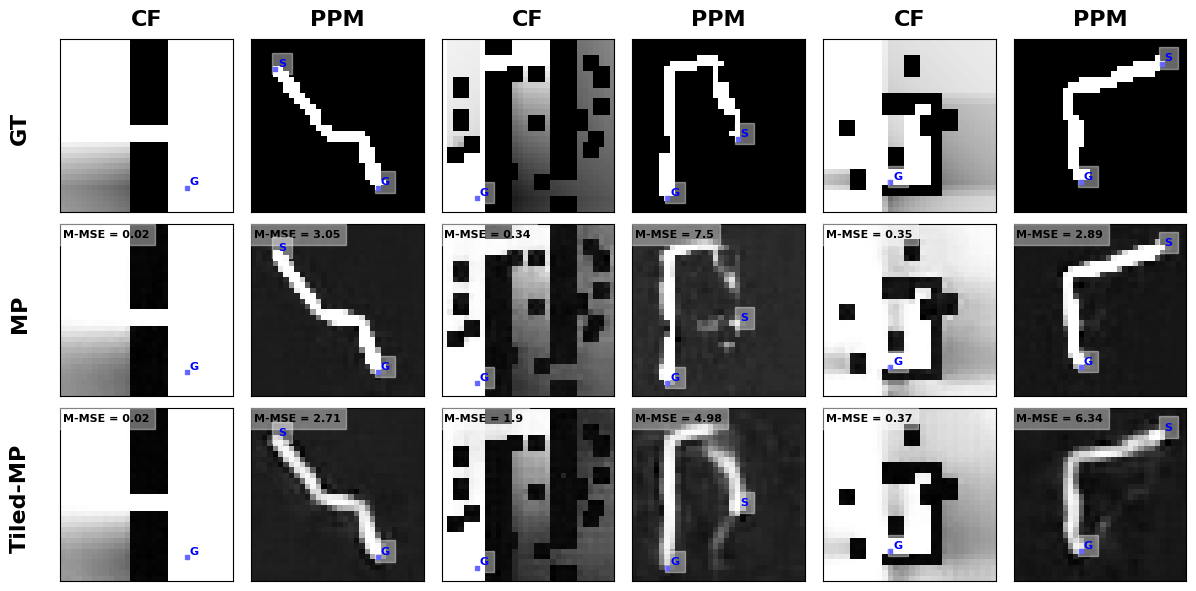

In [301]:
# do a statistical analysis on the test dataset
import pandas as pd
import time
import tqdm
import numpy as np
from PIL import Image
import torch

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

model_ppm = PPMModel_ppm()
model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))
model_cf = PPMModel_cf()
model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))

model_ppm.eval()
model_cf.eval()
model_ppm2.eval()
model_cf2.eval()
#model_ppm_cf.eval()

instance_complexity = -1

# input3 is a tensor of 0
input3 = torch.zeros(1, 1, 32, 32)

save = True
no = False
with torch.no_grad():
    fig, axs = plt.subplots(3, 6, figsize=(12, 6))
    types = []
    for hd in range(3):
        x_batch, y_batch = get_batch(x_test, y_test, 1)[0]
        type_of_map = x_batch[0].split("/")[-1].split("__")[0]
        while type_of_map in types or (type_of_map != "bugtrap_forest" and type_of_map != "gaps_and_forest" and type_of_map != "shifting_gaps"):
            x_batch, y_batch = get_batch(x_test, y_test, 1)[0]
            type_of_map = x_batch[0].split("/")[-1].split("__")[0]
        types.append(type_of_map)
        input1 = torch.tensor(np.array([np.array(Image.open(x_batch[0])) / 255]), dtype=torch.float32).unsqueeze(1)
        start_goal = torch.tensor(np.array([np.array(Image.open(x_batch[1])) / 255]), dtype=torch.float32).unsqueeze(1)
        
        start_goal_points = np.where(np.array(Image.open(x_batch[1])) == 255)
        start = (start_goal_points[0][0], start_goal_points[1][0])
        goal_pos = (start_goal_points[0][1], start_goal_points[1][1])
        
        # start_goal is goal image and we add the start position to it
        # image_goal is like input1 but zeros everywhere except at the goal position
        image_goal = np.zeros((32, 32))
        image_goal[goal_pos[0], goal_pos[1]] = 1
        goal = torch.tensor(np.array([image_goal]), dtype=torch.float32).unsqueeze(1)
        
        GT = create_GT(np.array(Image.open(x_batch[0])), image_goal)
        
        # add start
        image_goal[start[0], start[1]] = 1
        start_goal = torch.tensor(np.array([image_goal]), dtype=torch.float32).unsqueeze(1)
        
        
        input_cf2 = torch.cat((input1, goal, input3), dim=1)
        
        input_ppm2 = torch.cat((input1, start_goal, input3), dim=1)
        
        input_cf = torch.cat((input1, goal), dim=1)
        
        input_ppm = torch.cat((input1, start_goal), dim=1)
        
        output_ppm = model_ppm(input_ppm)
        output_ppm = output_ppm.detach().squeeze().numpy()
        
        output_cf = model_cf(input_cf)
        output_cf = output_cf.detach().squeeze().numpy()
        
        output_ppm2 = model_ppm2(input_ppm2)
        output_ppm2 = output_ppm2.detach().squeeze().numpy()
        
        output_cf2 = model_cf2(input_cf2)
        output_cf2 = output_cf2.detach().squeeze().numpy()
        
        def mse(pred, GT, mask):
            # apply mask
            pred = pred * mask
            GT = GT * mask
            return np.mean((pred - GT) ** 2)

        mask = np.array(Image.open(x_batch[0])) / 255
        mse_cf = mse(output_cf, GT / 255, mask)
        mse_ppm = mse(output_ppm, np.array(Image.open(y_batch)) / 255, mask)
        mse_cf2 = mse(output_cf2, GT / 255, mask)
        mse_ppm2 = mse(output_ppm2, np.array(Image.open(y_batch)) / 255, mask)
        
        print("MSE CF:", mse_cf)
        print("MSE PPM:", mse_ppm)
        print("MSE CF2:", mse_cf2)
        print("MSE PPM2:", mse_ppm2)
        
        mse_cf = mse_cf * 255
        mse_ppm = mse_ppm * 255
        mse_cf2 = mse_cf2 * 255
        mse_ppm2 = mse_ppm2 * 255
        
        
        axs[0, 0 + hd*2].imshow(GT, cmap='gray')
        axs[0, 0 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[0, 0 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[0, 0 + hd*2].set_xticks([])
        axs[0, 0 + hd*2].set_yticks([])
        axs[0, 0 + hd*2].set_title("CF", fontsize=16, color='black', pad=10, weight='bold')
        if hd == 0:
            t=axs[0, 0 + hd*2].text(-8, 16, "GT", fontsize=16, rotation=90, va='center', ha='center', color='black', weight='bold')
            t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[0, 1 + hd*2].imshow(np.array(Image.open(y_batch)), cmap='gray')
        axs[0, 1 + hd*2].set_xticks([])
        axs[0, 1 + hd*2].set_yticks([])
        axs[0, 1 + hd*2].set_title("PPM", fontsize=16, color='black', pad=10, weight='bold')
        axs[0, 1 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[0, 1 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[0, 1 + hd*2].scatter(start[1], start[0], c='blue', s=12, marker='s')
        t=axs[0, 1 + hd*2].text(start[1] + 0.5, start[0] -0.5 , "S", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[1, 0 + hd*2].set_xticks([])
        axs[1, 0 + hd*2].set_yticks([])
        axs[1, 0 + hd*2].imshow(output_cf, cmap='gray')
        axs[1, 0 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[1, 0 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        if hd == 0:
            t=axs[1, 0 + hd*2].text(-8, 16, "MP", fontsize=16, rotation=90, va='center', ha='center', color='black', weight='bold')
            t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[1, 0 + hd*2].text(0, 2, "M-MSE = " + str(round(mse_cf, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[1, 1 + hd*2].set_xticks([])
        axs[1, 1 + hd*2].set_yticks([])
        axs[1, 1 + hd*2].imshow(output_ppm, cmap='gray')
        axs[1, 1 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[1, 1 + hd*2].text(0, 2, "M-MSE = " + str(round(mse_ppm, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[1, 1 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[1, 1 + hd*2].text(start[1] + 0.5, start[0] -0.5 , "S", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[2, 0 + hd*2].set_xticks([])
        axs[2, 0 + hd*2].set_yticks([])
        axs[2, 0 + hd*2].imshow(output_cf2, cmap='gray')
        axs[2, 0 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[2, 0 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        if hd == 0:
            t=axs[2, 0 + hd*2].text(-8, 16, "Tiled-MP", fontsize=16, rotation=90, va='center', ha='center', color='black', weight='bold')
            t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[2, 0 + hd*2].text(0, 2, "M-MSE = " + str(round(mse_cf2, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[2, 1 + hd*2].set_xticks([])
        axs[2, 1 + hd*2].set_yticks([])
        axs[2, 1 + hd*2].imshow(output_ppm2, cmap='gray')
        axs[2, 1 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[2, 1 + hd*2].text(0, 2, "M-MSE = " + str(round(mse_ppm2, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[2, 1 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[2, 1 + hd*2].text(start[1] + 0.5, start[0] -0.5 , "S", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        
plt.tight_layout()
plt.savefig("inferences1.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Search examples on MP

In [ ]:
# do a statistical analysis on the test dataset
import pandas as pd
import time
import tqdm
import numpy as np
from PIL import Image
import torch

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

model_ppm = PPMModel_ppm()
model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))
model_cf = PPMModel_cf()
model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))

model_ppm.eval()
model_cf.eval()
model_ppm2.eval()
model_cf2.eval()
#model_ppm_cf.eval()

instance_complexity = -1

# input3 is a tensor of 0
input3 = torch.zeros(1, 1, 32, 32)

save = True
no = False
with torch.no_grad():
    for _ in range(10):
        types = []
        N = 3
        fig, axs = plt.subplots(2*N, 11, figsize=(20, 4*N))
        for n in range(N):
            if n == 1:
                n = 2
            elif n == 2:
                n = 4
            x_batch, y_batch = get_batch(x_test, y_test, 1)[0]
            type_of_map = x_batch[0].split("/")[-1].split("__")[0]
            while type_of_map in types:
                x_batch, y_batch = get_batch(x_test, y_test, 1)[0]
                type_of_map = x_batch[0].split("/")[-1].split("__")[0]
            types.append(type_of_map)
            input1 = torch.tensor(np.array([np.array(Image.open(x_batch[0])) / 255]), dtype=torch.float32).unsqueeze(1)
            goal_pos = (np.random.randint(0, 32), np.random.randint(0, 32))
            
            start = goal_pos
            trys = 0
            while manhattan_distance(start, goal_pos) < 30 or input1[0][0][start[0], start[1]] == 0 or dijkstra(input1[0][0], start, goal_pos) is None or (len(dijkstra(input1[0][0], start, goal_pos)) / manhattan_distance(start, goal_pos) < 1.05 and trys < 100):
                start = (np.random.randint(0, 32), np.random.randint(0, 32))
                goal_pos = (np.random.randint(0, 32), np.random.randint(0, 32))
                trys += 1
            
            # start_goal is goal image and we add the start position to it
            # image_goal is like input1 but zeros everywhere except at the goal position
            image_goal = np.zeros((32, 32))
            image_goal[goal_pos[0], goal_pos[1]] = 1
            goal = torch.tensor(np.array([image_goal]), dtype=torch.float32).unsqueeze(1)
            # add start
            image_goal[start[0], start[1]] = 1
            start_goal = torch.tensor(np.array([image_goal]), dtype=torch.float32).unsqueeze(1)
            
            input_cf2 = torch.cat((input1, goal, input3), dim=1)
            
            input_ppm2 = torch.cat((input1, start_goal, input3), dim=1)
            
            input_cf = torch.cat((input1, goal), dim=1)
            
            input_ppm = torch.cat((input1, start_goal), dim=1)
            
            output_ppm = model_ppm(input_ppm)
            output_ppm = output_ppm.detach().squeeze().numpy()
            
            output_cf = model_cf(input_cf)
            output_cf = output_cf.detach().squeeze().numpy()
            
            output_ppm2 = model_ppm2(input_ppm2)
            output_ppm2 = output_ppm2.detach().squeeze().numpy()
            
            output_cf2 = model_cf2(input_cf2)
            output_cf2 = output_cf2.detach().squeeze().numpy()
            
            path_cf, path_ppm_man, path_ppm_cf, path_GT, path_man, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, vis_cf, vis_ppm_man, vis_ppm_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_man = everything_new(2, input1[0][0], start, goal_pos, output_ppm, output_cf, 1.25)
            
            path_cf2, path_ppm_man2, path_ppm_cf2, path_GT2, path_man2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, vis_cf2, vis_ppm_man2, vis_ppm_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_man2 = everything_new(2, input1[0][0], start, goal_pos, output_ppm2, output_cf2, 1.25)
            
            paths = [path_man, path_cf, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, path_ppm_man, path_ppm_cf]
            viss = [vis_man, vis_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_ppm_man, vis_ppm_cf]
            paths2 = [path_man2, path_cf2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, path_ppm_man2, path_ppm_cf2]
            viss2 = [vis_man2, vis_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_ppm_man2, vis_ppm_cf2]
            titles = ["A*+MAN", "WA*+CF", "CF+0.25*PPM", "CF+0.50*PPM", "CF+0.75*PPM", "CF+1*PPM", "CF/PPM", "FS+PPM+MAN", "FS+PPM+CF"]
            path_lengths = [len(path) for path in paths if path is not None]
            vis_lengths = [len(vis) for vis in viss if vis is not None]
            path_lengths2 = [len(path) for path in paths2 if path is not None]
            vis_lengths2 = [len(vis) for vis in viss2 if vis is not None]
            
            if path_cf is None or path_cf2 is None:
                print("No path found")
                no = True
                break
            else:
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT) / manhattan_distance(start, goal_pos)
                output_cf = np.stack((output_cf,)*3, axis=-1)
                output_cf[start[0], start[1]] = [0, 0, 225/255]
                output_cf[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].imshow(output_cf)
                axs[n][0].set_xticks([])
                axs[n][0].set_yticks([])
                # write on the left outside this image: 'MP'
                axs[n][0].text(-5, 15, "MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                if n == 0:
                    axs[n][0].set_title("pred CF", fontsize=16, fontweight='bold', pad=10)
                for i, (path, vis) in enumerate(zip(paths, viss)):
                    input_image = np.array(Image.open(x_batch[0]))
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n][i+1].set_xticks([])
                    axs[n][i+1].set_yticks([])
                    axs[n][i+1].imshow(input_image)
                    if n == 0:  
                        axs[n][i+1].set_title(titles[i], fontsize=16, fontweight='bold', pad=10)
                    axs[n][i+1].text(0, 30.5, f"{path_lengths[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n][i+1].text(31, 30.5, f"{vis_lengths[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    # add start and goal labels
                    axs[n][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm = np.stack((output_ppm,)*3, axis=-1)
                output_ppm[start[0], start[1]] = [0, 0, 225/255]
                output_ppm[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][10].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][10].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][10].imshow(output_ppm, cmap='gray')
                axs[n][10].set_xticks([])
                axs[n][10].set_yticks([])
                if n == 0:
                    axs[n][10].set_title("pred PPM", fontsize=16, fontweight='bold', pad=10)
                axs[n][10].text(1, 3, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
                
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT2) / manhattan_distance(start, goal_pos)
                output_cf2 = np.stack((output_cf2,)*3, axis=-1)
                output_cf2[start[0], start[1]] = [0, 0, 225/255]
                output_cf2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].imshow(output_cf2)
                axs[n+1][0].set_xticks([])
                axs[n+1][0].set_yticks([])
                axs[n+1][0].text(-5, 15, "Tiled-MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                for i, (path, vis) in enumerate(zip(paths2, viss2)):
                    input_image = np.array(Image.open(x_batch[0]))
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n+1][i+1].set_xticks([])
                    axs[n+1][i+1].set_yticks([])
                    axs[n+1][i+1].imshow(input_image)
                    axs[n+1][i+1].text(0, 30.5, f"{path_lengths2[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n+1][i+1].text(31, 30.5, f"{vis_lengths2[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    axs[n+1][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n+1][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm2 = np.stack((output_ppm2,)*3, axis=-1)
                output_ppm2[start[0], start[1]] = [0, 0, 225/255]
                output_ppm2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][10].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][10].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][10].imshow(output_ppm2, cmap='gray')
                axs[n+1][10].set_xticks([])
                axs[n+1][10].set_yticks([])
                axs[n+1][10].text(1, 3, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
        plt.tight_layout()
        if not no:
            if save:
                ti = time.time()
                plt.savefig("pictures32/examples_" + str(ti) + ".pdf", dpi = 300, bbox_inches='tight')
                print("examplesresized_" + str(ti) + ".pdf")
            plt.show()
        else:
            plt.close()

In [ ]:
# do a statistical analysis on the test dataset
import pandas as pd
import time
import tqdm
import numpy as np
from PIL import Image
import torch

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

model_ppm = PPMModel_ppm()
model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))
model_cf = PPMModel_cf()
model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))

model_ppm.eval()
model_cf.eval()
model_ppm2.eval()
model_cf2.eval()
#model_ppm_cf.eval()

instance_complexity = -1

# input3 is a tensor of 0
input3 = torch.zeros(1, 1, 32, 32)

save = True
no = False
with torch.no_grad():
    for _ in range(10):
        types = []
        N = 3
        fig, axs = plt.subplots(2*N, 8, figsize=(16, 4*N))
        for n in range(N):
            if n == 1:
                n = 2
            elif n == 2:
                n = 4
            x_batch, y_batch = get_batch(x_test, y_test, 1)[0]
            type_of_map = x_batch[0].split("/")[-1].split("__")[0]
            while type_of_map in types:
                x_batch, y_batch = get_batch(x_test, y_test, 1)[0]
                type_of_map = x_batch[0].split("/")[-1].split("__")[0]
            types.append(type_of_map)
            input1 = torch.tensor(np.array([np.array(Image.open(x_batch[0])) / 255]), dtype=torch.float32).unsqueeze(1)
            goal_pos = (np.random.randint(0, 32), np.random.randint(0, 32))
            
            start = goal_pos
            trys = 0
            while manhattan_distance(start, goal_pos) < 30 or input1[0][0][start[0], start[1]] == 0 or dijkstra(input1[0][0], start, goal_pos) is None or (len(dijkstra(input1[0][0], start, goal_pos)) / manhattan_distance(start, goal_pos) < 1.05 and trys < 100):
                start = (np.random.randint(0, 32), np.random.randint(0, 32))
                goal_pos = (np.random.randint(0, 32), np.random.randint(0, 32))
                trys += 1
            
            # start_goal is goal image and we add the start position to it
            # image_goal is like input1 but zeros everywhere except at the goal position
            image_goal = np.zeros((32, 32))
            image_goal[goal_pos[0], goal_pos[1]] = 1
            goal = torch.tensor(np.array([image_goal]), dtype=torch.float32).unsqueeze(1)
            # add start
            image_goal[start[0], start[1]] = 1
            start_goal = torch.tensor(np.array([image_goal]), dtype=torch.float32).unsqueeze(1)
            
            input_cf2 = torch.cat((input1, goal, input3), dim=1)
            
            input_ppm2 = torch.cat((input1, start_goal, input3), dim=1)
            
            input_cf = torch.cat((input1, goal), dim=1)
            
            input_ppm = torch.cat((input1, start_goal), dim=1)
            
            output_ppm = model_ppm(input_ppm)
            output_ppm = output_ppm.detach().squeeze().numpy()
            
            output_cf = model_cf(input_cf)
            output_cf = output_cf.detach().squeeze().numpy()
            
            output_ppm2 = model_ppm2(input_ppm2)
            output_ppm2 = output_ppm2.detach().squeeze().numpy()
            
            output_cf2 = model_cf2(input_cf2)
            output_cf2 = output_cf2.detach().squeeze().numpy()
            
            path_cf, path_ppm_man, path_ppm_cf, path_GT, path_man, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, vis_cf, vis_ppm_man, vis_ppm_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_man = everything_new(2, input1[0][0], start, goal_pos, output_ppm, output_cf, 1.25)
            
            path_cf2, path_ppm_man2, path_ppm_cf2, path_GT2, path_man2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, vis_cf2, vis_ppm_man2, vis_ppm_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_man2 = everything_new(2, input1[0][0], start, goal_pos, output_ppm2, output_cf2, 1.25)
            
            paths = [path_man, path_cf, path_cf_ppm25, path_cf_sur_ppm, path_ppm_man, path_ppm_cf]
            viss = [vis_man, vis_cf, vis_cf_ppm25, vis_cf_sur_ppm, vis_ppm_man, vis_ppm_cf]
            paths2 = [path_man2, path_cf2, path_cf_ppm252, path_cf_sur_ppm2, path_ppm_man2, path_ppm_cf2]
            viss2 = [vis_man2, vis_cf2, vis_cf_ppm252, vis_cf_sur_ppm2, vis_ppm_man2, vis_ppm_cf2]
            titles = ["A*+MAN", "WA*+CF", "CF+0.25*PPM", "CF/PPM", "FS+PPM+MAN", "FS+PPM+CF"]
            path_lengths = [len(path) for path in paths if path is not None]
            vis_lengths = [len(vis) for vis in viss if vis is not None]
            path_lengths2 = [len(path) for path in paths2 if path is not None]
            vis_lengths2 = [len(vis) for vis in viss2 if vis is not None]
            
            if path_cf is None or path_cf2 is None:
                print("No path found")
                no = True
                break
            else:
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT) / manhattan_distance(start, goal_pos)
                output_cf = np.stack((output_cf,)*3, axis=-1)
                output_cf[start[0], start[1]] = [0, 0, 225/255]
                output_cf[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].imshow(output_cf)
                axs[n][0].set_xticks([])
                axs[n][0].set_yticks([])
                # write on the left outside this image: 'MP'
                axs[n][0].text(-5, 15, "MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                if n == 0:
                    axs[n][0].set_title("pred CF", fontsize=16, fontweight='bold', pad=10)
                for i, (path, vis) in enumerate(zip(paths, viss)):
                    input_image = np.array(Image.open(x_batch[0]))
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n][i+1].set_xticks([])
                    axs[n][i+1].set_yticks([])
                    axs[n][i+1].imshow(input_image)
                    if n == 0:  
                        axs[n][i+1].set_title(titles[i], fontsize=16, fontweight='bold', pad=10)
                    axs[n][i+1].text(0, 30.5, f"{path_lengths[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n][i+1].text(31, 30.5, f"{vis_lengths[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    # add start and goal labels
                    axs[n][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm = np.stack((output_ppm,)*3, axis=-1)
                output_ppm[start[0], start[1]] = [0, 0, 225/255]
                output_ppm[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][7].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][7].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][7].imshow(output_ppm, cmap='gray')
                axs[n][7].set_xticks([])
                axs[n][7].set_yticks([])
                if n == 0:
                    axs[n][7].set_title("pred PPM", fontsize=16, fontweight='bold', pad=10)
                axs[n][7].text(1, 3, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
                
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT2) / manhattan_distance(start, goal_pos)
                output_cf2 = np.stack((output_cf2,)*3, axis=-1)
                output_cf2[start[0], start[1]] = [0, 0, 225/255]
                output_cf2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].imshow(output_cf2)
                axs[n+1][0].set_xticks([])
                axs[n+1][0].set_yticks([])
                axs[n+1][0].text(-5, 15, "Tiled-MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                for i, (path, vis) in enumerate(zip(paths2, viss2)):
                    input_image = np.array(Image.open(x_batch[0]))
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n+1][i+1].set_xticks([])
                    axs[n+1][i+1].set_yticks([])
                    axs[n+1][i+1].imshow(input_image)
                    axs[n+1][i+1].text(0, 30.5, f"{path_lengths2[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n+1][i+1].text(31, 30.5, f"{vis_lengths2[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    axs[n+1][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n+1][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm2 = np.stack((output_ppm2,)*3, axis=-1)
                output_ppm2[start[0], start[1]] = [0, 0, 225/255]
                output_ppm2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][7].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][7].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][7].imshow(output_ppm2, cmap='gray')
                axs[n+1][7].set_xticks([])
                axs[n+1][7].set_yticks([])
                axs[n+1][7].text(1, 3, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
        plt.tight_layout()
        if not no:
            if save:
                ti = time.time()
                plt.savefig("pictures32/new_examples_" + str(ti) + ".pdf", dpi = 300, bbox_inches='tight')
                print("examplesresized_" + str(ti) + ".pdf")
            plt.show()
        else:
            plt.close()

# Tiled-MP dataset

In [113]:
import glob
import tqdm
import cv2
import numpy as np

class Dataset:
    def __init__(self, root, rem512=False, rem256=False, rem16=False, uniform=False, rem128=False):
        files = []
        dict = {}
        
        def get_base_filename(filename):
            return filename.split('_start')[0] + '.png'
        
        for file in glob.glob(root + '/*'):
            if rem512:
                if "512x512" in file:
                    continue
            if rem256:
                if "256x256" in file:
                    continue
            if rem16:
                if "16x16" in file:
                    continue
            if rem128:
                if "128x128" in file:
                    continue
            if "GT" not in file and "start" not in file:
                base_filename = file.split(".")[0]
                for i in range(2):
                    files.append(base_filename + "_" + str(i) + ".png")
            elif "start" in file:
                base_filename = get_base_filename(file)
                dict[base_filename] = file
        
        if uniform:
            files_16, files_32, files_64, files_96, files_128, files_256, files_512 = [], [], [], [], [], [], []
            for file in files:
                if "16x16" in file:
                    files_16.append(file)
                elif "32x32" in file:
                    files_32.append(file)
                elif "64x64" in file:
                    files_64.append(file)
                elif "96x96" in file:
                    files_96.append(file)
                elif "128x128" in file:
                    files_128.append(file)
                elif "256x256" in file:
                    files_256.append(file)
                elif "512x512" in file:
                    files_512.append(file)
                
            min = 200 # TODO: change 
            for files in [files_16, files_32, files_64, files_96, files_128, files_256, files_512]:
                if len(files) < min and len(files) > 0:
                    min = len(files)
            if len(files_16) > 0:
                files_16 = np.random.choice(files_16, min, replace=False)
            if len(files_32) > 0:
                files_32 = np.random.choice(files_32, min, replace=False)
            if len(files_64) > 0:
                files_64 = np.random.choice(files_64, min, replace=False)
            if len(files_96) > 0:
                files_96 = np.random.choice(files_96, min, replace=False)
            if len(files_128) > 0:
                files_128 = np.random.choice(files_128, min, replace=False)
            if len(files_256) > 0:
                files_256 = np.random.choice(files_256, min, replace=False)
            if len(files_512) > 0:
                files_512 = np.random.choice(files_512, min, replace=False)
            files = list(files_16) + list(files_32) + list(files_64) + list(files_96) + list(files_128) + list(files_256) + list(files_512)
        
        self.inputs1 = []
        self.inputs2 = []
        self.targets = []
        
        for file in tqdm.tqdm(files):
            name = file.split('.')[0]
            self.inputs1.append(name[:-2] + ".png")
            self.inputs2.append(dict[file])
            self.targets.append([name + "_GT_cf.png", name + "_GT_ppm.png"])
    
    def __len__(self):
        return len(self.inputs1)
    
    def __getitem__(self, idx):
        input1 = cv2.imread(self.inputs1[idx], cv2.IMREAD_GRAYSCALE)
        input2 = cv2.imread(self.inputs2[idx], cv2.IMREAD_GRAYSCALE)
        targets = [cv2.imread(target, cv2.IMREAD_GRAYSCALE) for target in self.targets[idx]]
        
        goal = self.inputs2[idx].split('_end-')[1].split('.png')[0].split('_')
        goal = (int(goal[0]), int(goal[1]))
        # create an image the same size as input1 with the goal point
        input3 = np.zeros(input1.shape, dtype=np.float32)
        input3[goal[0], goal[1]] = 1
        input3 = input3.astype('float32')
        
        input1 = input1.astype('float32')
        input2 = input2.astype('float32')
        targets = [target.astype('float32') for target in targets]
        
        return input1, input2, input3, targets

In [114]:
resized_test_dataset = Dataset("C:/Users/Elie/Desktop/Individual Research Project/Data/MP dataset/32x MP_dataset_unclassed_resized_all/test", rem512=True, rem256=False, rem16=True, uniform=True, rem128=False)

100%|██████████| 1000/1000 [00:00<00:00, 166791.43it/s]


In [115]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

class Loader_non_resize:
    def __init__(self, dataset, batch_size, device):
        self.device = device
        split_indices = list(range(len(dataset)))
        sampler = torch.utils.data.sampler.SubsetRandomSampler(split_indices)
        self.loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=0, collate_fn=self.collate_fn)
    
    def __len__(self):
        return len(self.loader)
    
    def __iter__(self):
        for data in self.loader:
            yield [d.to(self.device) for d in data]
    
    def collate_fn(self, batch):
        images1 = [Image.fromarray((item[0]).astype('uint8')) for item in batch]
        images2 = [Image.fromarray((item[1]).astype('uint8')) for item in batch]
        images3 = [Image.fromarray((item[2]).astype('uint8')) for item in batch]
        targets = [Image.fromarray((target).astype('uint8')) for item in batch for target in item[3]]
        
        # to tensor
        transform = transforms.ToTensor()
        images1 = [transform(image) for image in images1]
        images2 = [transform(image) for image in images2]
        images3 = [transform(image) for image in images3]
        targets = [transform(image) for image in targets]

        # return torch stack
        return torch.stack(images1), torch.stack(images2), torch.stack(images3), torch.stack(targets)

# Search examples on Tiled-MP

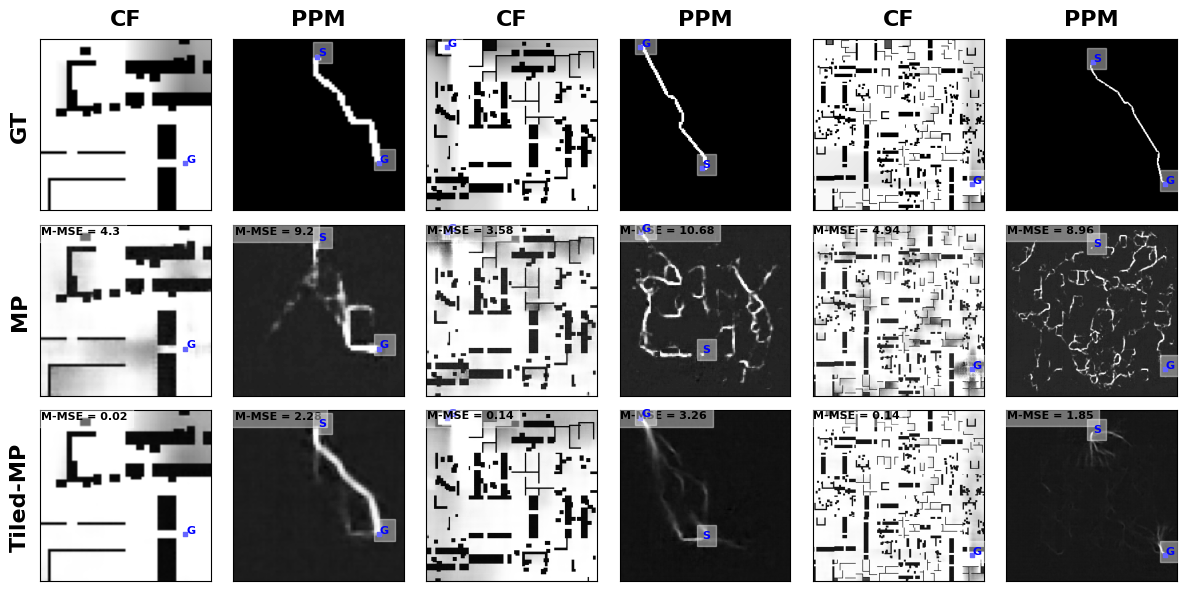

In [335]:
# do a statistical analysis on the test dataset
import pandas as pd
import time
import tqdm
import numpy as np
from PIL import Image
import torch

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

model_ppm = PPMModel_ppm()
model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))
model_cf = PPMModel_cf()
model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))

model_ppm.eval()
model_cf.eval()
model_ppm2.eval()
model_cf2.eval()
#model_ppm_cf.eval()

model_cf.to('cuda')
model_ppm.to('cuda')
model_cf2.to('cuda')
model_ppm2.to('cuda')

instance_complexity = -1

# input3 is a tensor of 0
input3 = torch.zeros(1, 1, 32, 32)

# create Loader
loader = Loader_non_resize(resized_test_dataset, 1, 'cuda')


save = True
no = False
with torch.no_grad():
    fig, axs = plt.subplots(3, 6, figsize=(12, 6))
    sizes = []
    for hd in range(3):
        input1, input2, input3, targets = next(iter(loader))
        size = str(input1[0][0].size()[0])
        while size in sizes or size == "32":
            input1, input2, input3, targets = next(iter(loader))
            size = str(input1[0][0].size()[0])
        sizes.append(size)
        input4 = torch.zeros_like(input1)
        input1size = input1.size()
        # get goal position from input3
        goal_pos = np.where(input3[0][0].cpu().numpy() != 0)
        goal_pos = (goal_pos[0][0], goal_pos[1][0])
        # get start position from input2
        dstart = np.where(input2[0][0].cpu().numpy() != 0)
        start = (dstart[0][0], dstart[1][0])
        if start == goal_pos:
            start = (dstart[0][1], dstart[1][1])
        start_goal = torch.zeros_like(input1)
        start_goal[0][0][start[0], start[1]] = 1
        start_goal[0][0][goal_pos[0], goal_pos[1]] = 1
        goal = torch.zeros_like(input1)
        goal[0][0][goal_pos[0], goal_pos[1]] = 1
        input_cf = torch.cat((input1, goal), dim=1)
        input_ppm = torch.cat((input1, start_goal), dim=1)
        input_cf2 = torch.cat((input1, goal, input4), dim=1)
        input_ppm2 = torch.cat((input1, start_goal, input4), dim=1)

        output_cf = model_cf(input_cf)
        output_ppm = model_ppm(input_ppm)
        output_cf2 = model_cf2(input_cf2)
        output_ppm2 = model_ppm2(input_ppm2)
        
        output_ppm = output_ppm.detach().cpu().numpy().squeeze()
        output_cf = output_cf.detach().cpu().numpy().squeeze()

        output_ppm2 = output_ppm2.detach().cpu().numpy().squeeze()
        output_cf2 = output_cf2.detach().cpu().numpy().squeeze()
        
        GT = targets[0][0].cpu().numpy()
        
        def mse(pred, GT, mask):
            # apply mask
            pred = pred * mask
            GT = GT * mask
            return np.mean((pred - GT) ** 2)

        mask = input1[0][0].cpu().numpy()
        mse_cf = mse(output_cf, GT, mask)
        mse_ppm = mse(output_ppm, targets[1][0].cpu().numpy(), mask)
        mse_cf2 = mse(output_cf2, GT, mask)
        mse_ppm2 = mse(output_ppm2, targets[1][0].cpu().numpy(), mask)
        
        mse_cf = mse_cf * 255
        mse_ppm = mse_ppm * 255
        mse_cf2 = mse_cf2 * 255
        mse_ppm2 = mse_ppm2 * 255
        
        input1size = input1size[2]
        
        
        axs[0, 0 + hd*2].imshow(GT, cmap='gray')
        axs[0, 0 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[0, 0 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[0, 0 + hd*2].set_xticks([])
        axs[0, 0 + hd*2].set_yticks([])
        axs[0, 0 + hd*2].set_title("CF", fontsize=16, color='black', pad=10, weight='bold')
        if hd == 0:
            t=axs[0, 0 + hd*2].text(-input1size//8, input1size//2, "GT", fontsize=16, rotation=90, va='center', ha='center', color='black', weight='bold')
            t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[0, 1 + hd*2].imshow(targets[1][0].cpu().numpy(), cmap='gray')
        axs[0, 1 + hd*2].set_xticks([])
        axs[0, 1 + hd*2].set_yticks([])
        axs[0, 1 + hd*2].set_title("PPM", fontsize=16, color='black', pad=10, weight='bold')
        axs[0, 1 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[0, 1 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[0, 1 + hd*2].scatter(start[1], start[0], c='blue', s=12, marker='s')
        t=axs[0, 1 + hd*2].text(start[1] + 0.5, start[0] -0.5 , "S", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[1, 0 + hd*2].set_xticks([])
        axs[1, 0 + hd*2].set_yticks([])
        axs[1, 0 + hd*2].imshow(output_cf, cmap='gray')
        axs[1, 0 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[1, 0 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        if hd == 0:
            t=axs[1, 0 + hd*2].text(-input1size//8, input1size//2, "MP", fontsize=16, rotation=90, va='center', ha='center', color='black', weight='bold')
            t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[1, 0 + hd*2].text(0, input1size//20, "M-MSE = " + str(round(mse_cf, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[1, 1 + hd*2].set_xticks([])
        axs[1, 1 + hd*2].set_yticks([])
        axs[1, 1 + hd*2].imshow(output_ppm, cmap='gray')
        axs[1, 1 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[1, 1 + hd*2].text(0, input1size//20, "M-MSE = " + str(round(mse_ppm, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[1, 1 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[1, 1 + hd*2].text(start[1] + 0.5, start[0] -0.5 , "S", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[2, 0 + hd*2].set_xticks([])
        axs[2, 0 + hd*2].set_yticks([])
        axs[2, 0 + hd*2].imshow(output_cf2, cmap='gray')
        axs[2, 0 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[2, 0 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        if hd == 0:
            t=axs[2, 0 + hd*2].text(-input1size//8, input1size//2, "Tiled-MP", fontsize=16, rotation=90, va='center', ha='center', color='black', weight='bold')
            t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[2, 0 + hd*2].text(0, input1size//20, "M-MSE = " + str(round(mse_cf2, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        axs[2, 1 + hd*2].set_xticks([])
        axs[2, 1 + hd*2].set_yticks([])
        axs[2, 1 + hd*2].imshow(output_ppm2, cmap='gray')
        axs[2, 1 + hd*2].scatter(goal_pos[1], goal_pos[0], c='blue', s=12, marker='s')
        t=axs[2, 1 + hd*2].text(0, input1size//20, "M-MSE = " + str(round(mse_ppm2, 2)), fontsize=8, color='black', weight='bold', backgroundcolor='white')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[2, 1 + hd*2].text(goal_pos[1] + 0.5, goal_pos[0] -0.5 , "G", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        t=axs[2, 1 + hd*2].text(start[1] + 0.5, start[0] -0.5 , "S", fontsize=8, color='blue', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='white'))
        
plt.tight_layout()
plt.savefig("inferences2.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# do a statistical analysis on the test dataset
import pandas as pd
import time
import tqdm
import numpy as np
from PIL import Image

model_ppm = PPMModel_ppm()
model_cf = PPMModel_cf()
#model_ppm_cf = PPMModel()

model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))

model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

#model_ppm_cf.load_state_dict(torch.load("new_model_aug_both.pth"))

model_ppm.to('cuda')
model_cf.to('cuda')
#model_ppm_cf.to('cuda')
model_ppm2.to('cuda')
model_cf2.to('cuda')

model_ppm.eval()
model_cf.eval()
#model_ppm_cf.eval()
model_ppm2.eval()
model_cf2.eval()

# create Loader
loader = Loader_non_resize(resized_test_dataset, 1, 'cuda')

# ici

instance_complexity = -1

save = True
no = False
with torch.no_grad():
    for _ in range(10):
        sizes = []
        N = 3
        fig, axs = plt.subplots(2*N, 11, figsize=(20, 4*N))
        for n in range(N):
            if n == 1:
                n = 2
            elif n == 2:
                n = 4
            input1, input2, input3, targets = next(iter(loader))
            size = str(input1[0][0].size()[0])
            while size in sizes or size == "32":
                input1, input2, input3, targets = next(iter(loader))
                size = str(input1[0][0].size()[0])
            sizes.append(size)
            input4 = torch.zeros_like(input1)
            input1size = input1.size()
            start = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
            goal_pos = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
            trys = 0
            while manhattan_distance(start, goal_pos) < input1size[2]//2 or input1[0][0][start[0], start[1]] == 0 or dijkstra(input1[0][0], start, goal_pos) is None or (len(dijkstra(input1[0][0], start, goal_pos)) / manhattan_distance(start, goal_pos) < 1.05 and trys < 100) or input1[0][0][goal_pos[0], goal_pos[1]] == 0:
                start = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
                goal_pos = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
                trys += 1
            start_goal = torch.zeros_like(input1)
            start_goal[0][0][start[0], start[1]] = 1
            start_goal[0][0][goal_pos[0], goal_pos[1]] = 1
            goal = torch.zeros_like(input1)
            goal[0][0][goal_pos[0], goal_pos[1]] = 1
            input_cf = torch.cat((input1, goal), dim=1)
            input_ppm = torch.cat((input1, start_goal), dim=1)
            input_cf2 = torch.cat((input1, goal, input4), dim=1)
            input_ppm2 = torch.cat((input1, start_goal, input4), dim=1)

            output_cf = model_cf(input_cf)
            output_ppm = model_ppm(input_ppm)
            output_cf2 = model_cf2(input_cf2)
            output_ppm2 = model_ppm2(input_ppm2)
            
            output_ppm = output_ppm.detach().cpu().numpy().squeeze()
            output_cf = output_cf.detach().cpu().numpy().squeeze()

            output_ppm2 = output_ppm2.detach().cpu().numpy().squeeze()
            output_cf2 = output_cf2.detach().cpu().numpy().squeeze()
            
            
            path_cf, path_ppm_man, path_ppm_cf, path_GT, path_man, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, vis_cf, vis_ppm_man, vis_ppm_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_man = everything_new(2, input1[0][0], start, goal_pos, output_ppm, output_cf, 1.25)
            
            path_cf2, path_ppm_man2, path_ppm_cf2, path_GT2, path_man2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, vis_cf2, vis_ppm_man2, vis_ppm_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_man2 = everything_new(2, input1[0][0], start, goal_pos, output_ppm2, output_cf2, 1.25)
            
            paths = [path_man, path_cf, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, path_ppm_man, path_ppm_cf]
            viss = [vis_man, vis_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_ppm_man, vis_ppm_cf]
            paths2 = [path_man2, path_cf2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, path_ppm_man2, path_ppm_cf2]
            viss2 = [vis_man2, vis_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_ppm_man2, vis_ppm_cf2]
            titles = ["A*+MAN", "WA*+CF", "CF+0.25*PPM", "CF+0.50*PPM", "CF+0.75*PPM", "CF+1*PPM", "CF/PPM", "FS+PPM+MAN", "FS+PPM+CF"]
            path_lengths = [len(path) for path in paths if path is not None]
            vis_lengths = [len(vis) for vis in viss if vis is not None]
            path_lengths2 = [len(path) for path in paths2 if path is not None]
            vis_lengths2 = [len(vis) for vis in viss2 if vis is not None]
            
            if path_cf is None or path_cf2 is None:
                print("No path found")
                no = True
                break
            else:
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT) / manhattan_distance(start, goal_pos)
                output_cf = np.stack((output_cf,)*3, axis=-1)
                output_cf[start[0], start[1]] = [0, 0, 225/255]
                output_cf[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].imshow(output_cf)
                axs[n][0].set_xticks([])
                axs[n][0].set_yticks([])
                # write on the left outside this image: 'MP'
                axs[n][0].text(-input1size[2]//6, input1size[2]//2, "MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                if n == 0:
                    axs[n][0].set_title("pred CF", fontsize=16, fontweight='bold', pad=10)
                for i, (path, vis) in enumerate(zip(paths, viss)):
                    input_image = np.array(input1[0][0].cpu().numpy())
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n][i+1].set_xticks([])
                    axs[n][i+1].set_yticks([])
                    axs[n][i+1].imshow(input_image)
                    if n == 0:  
                        axs[n][i+1].set_title(titles[i], fontsize=16, fontweight='bold', pad=10)
                    axs[n][i+1].text(0, input1size[2]-1.5, f"{path_lengths[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n][i+1].text(input1size[3]-1, input1size[2]-1.5, f"{vis_lengths[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    # add start and goal labels
                    axs[n][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm = np.stack((output_ppm,)*3, axis=-1)
                output_ppm[start[0], start[1]] = [0, 0, 225/255]
                output_ppm[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][10].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][10].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][10].imshow(output_ppm, cmap='gray')
                axs[n][10].set_xticks([])
                axs[n][10].set_yticks([])
                if n == 0:
                    axs[n][10].set_title("pred PPM", fontsize=16, fontweight='bold', pad=10)
                axs[n][10].text(input1size[3]//30, input1size[2]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
                
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT2) / manhattan_distance(start, goal_pos)
                output_cf2 = np.stack((output_cf2,)*3, axis=-1)
                output_cf2[start[0], start[1]] = [0, 0, 225/255]
                output_cf2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].imshow(output_cf2)
                axs[n+1][0].set_xticks([])
                axs[n+1][0].set_yticks([])
                axs[n+1][0].text(-input1size[2]//6, input1size[2]//2, "Tiled-MP", fontsize=14, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                for i, (path, vis) in enumerate(zip(paths2, viss2)):
                    input_image = np.array(input1[0][0].cpu().numpy())
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n+1][i+1].set_xticks([])
                    axs[n+1][i+1].set_yticks([])
                    axs[n+1][i+1].imshow(input_image)
                    axs[n+1][i+1].text(0, input1size[2]-1.5, f"{path_lengths2[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n+1][i+1].text(input1size[3]-1, input1size[2]-1.5, f"{vis_lengths2[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    axs[n+1][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n+1][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm2 = np.stack((output_ppm2,)*3, axis=-1)
                output_ppm2[start[0], start[1]] = [0, 0, 225/255]
                output_ppm2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][10].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][10].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][10].imshow(output_ppm2, cmap='gray')
                axs[n+1][10].set_xticks([])
                axs[n+1][10].set_yticks([])
                axs[n+1][10].text(input1size[3]//30, input1size[2]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
        plt.tight_layout()
        if not no:
            if save:
                ti = time.time()
                plt.savefig("picturesresized/examples_" + str(ti) + ".pdf", dpi = 300, bbox_inches='tight')
                print("examples2_" + str(ti) + ".pdf")
            plt.show()
        else:
            plt.close()

In [ ]:
# do a statistical analysis on the test dataset
import pandas as pd
import time
import tqdm
import numpy as np
from PIL import Image

model_ppm = PPMModel_ppm()
model_cf = PPMModel_cf()
#model_ppm_cf = PPMModel()

model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))

model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

#model_ppm_cf.load_state_dict(torch.load("new_model_aug_both.pth"))

model_ppm.to('cuda')
model_cf.to('cuda')
#model_ppm_cf.to('cuda')
model_ppm2.to('cuda')
model_cf2.to('cuda')

model_ppm.eval()
model_cf.eval()
#model_ppm_cf.eval()
model_ppm2.eval()
model_cf2.eval()

# create Loader
loader = Loader_non_resize(resized_test_dataset, 1, 'cuda')

# ici

instance_complexity = -1

save = True
no = False
with torch.no_grad():
    for _ in range(10):
        sizes = []
        N = 3
        fig, axs = plt.subplots(2*N, 8, figsize=(16, 4*N))
        for n in range(N):
            if n == 1:
                n = 2
            elif n == 2:
                n = 4
            input1, input2, input3, targets = next(iter(loader))
            size = str(input1[0][0].size()[0])
            while size in sizes or size == "32":
                input1, input2, input3, targets = next(iter(loader))
                size = str(input1[0][0].size()[0])
            sizes.append(size)
            input4 = torch.zeros_like(input1)
            input1size = input1.size()
            start = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
            goal_pos = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
            trys = 0
            while manhattan_distance(start, goal_pos) < input1size[2]//2 or input1[0][0][start[0], start[1]] == 0 or dijkstra(input1[0][0], start, goal_pos) is None or (len(dijkstra(input1[0][0], start, goal_pos)) / manhattan_distance(start, goal_pos) < 1.05 and trys < 100) or input1[0][0][goal_pos[0], goal_pos[1]] == 0:
                start = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
                goal_pos = (np.random.randint(0, input1size[2]), np.random.randint(0, input1size[3]))
                trys += 1
            start_goal = torch.zeros_like(input1)
            start_goal[0][0][start[0], start[1]] = 1
            start_goal[0][0][goal_pos[0], goal_pos[1]] = 1
            goal = torch.zeros_like(input1)
            goal[0][0][goal_pos[0], goal_pos[1]] = 1
            input_cf = torch.cat((input1, goal), dim=1)
            input_ppm = torch.cat((input1, start_goal), dim=1)
            input_cf2 = torch.cat((input1, goal, input4), dim=1)
            input_ppm2 = torch.cat((input1, start_goal, input4), dim=1)

            output_cf = model_cf(input_cf)
            output_ppm = model_ppm(input_ppm)
            output_cf2 = model_cf2(input_cf2)
            output_ppm2 = model_ppm2(input_ppm2)
            
            output_ppm = output_ppm.detach().cpu().numpy().squeeze()
            output_cf = output_cf.detach().cpu().numpy().squeeze()

            output_ppm2 = output_ppm2.detach().cpu().numpy().squeeze()
            output_cf2 = output_cf2.detach().cpu().numpy().squeeze()
            
            
            path_cf, path_ppm_man, path_ppm_cf, path_GT, path_man, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, vis_cf, vis_ppm_man, vis_ppm_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_man = everything_new(2, input1[0][0], start, goal_pos, output_ppm, output_cf, 1.25)
            
            path_cf2, path_ppm_man2, path_ppm_cf2, path_GT2, path_man2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, vis_cf2, vis_ppm_man2, vis_ppm_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_man2 = everything_new(2, input1[0][0], start, goal_pos, output_ppm2, output_cf2, 1.25)
            
            paths = [path_man, path_cf, path_cf_ppm1, path_cf_sur_ppm, path_ppm_man, path_ppm_cf]
            viss = [vis_man, vis_cf, vis_cf_ppm1, vis_cf_sur_ppm, vis_ppm_man, vis_ppm_cf]
            paths2 = [path_man2, path_cf2, path_cf_ppm12, path_cf_sur_ppm2, path_ppm_man2, path_ppm_cf2]
            viss2 = [vis_man2, vis_cf2, vis_cf_ppm12, vis_cf_sur_ppm2, vis_ppm_man2, vis_ppm_cf2]
            titles = ["A*+MAN", "WA*+CF", "CF+1*PPM", "CF/PPM", "FS+PPM+MAN", "FS+PPM+CF"]
            path_lengths = [len(path) for path in paths if path is not None]
            vis_lengths = [len(vis) for vis in viss if vis is not None]
            path_lengths2 = [len(path) for path in paths2 if path is not None]
            vis_lengths2 = [len(vis) for vis in viss2 if vis is not None]
            
            if path_cf is None or path_cf2 is None:
                print("No path found")
                no = True
                break
            else:
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT) / manhattan_distance(start, goal_pos)
                output_cf = np.stack((output_cf,)*3, axis=-1)
                output_cf[start[0], start[1]] = [0, 0, 225/255]
                output_cf[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].imshow(output_cf)
                axs[n][0].set_xticks([])
                axs[n][0].set_yticks([])
                # write on the left outside this image: 'MP'
                axs[n][0].text(-input1size[2]//6, input1size[2]//2, "MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                if n == 0:
                    axs[n][0].set_title("pred CF", fontsize=16, fontweight='bold', pad=10)
                for i, (path, vis) in enumerate(zip(paths, viss)):
                    input_image = np.array(input1[0][0].cpu().numpy())
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n][i+1].set_xticks([])
                    axs[n][i+1].set_yticks([])
                    axs[n][i+1].imshow(input_image)
                    if n == 0:  
                        axs[n][i+1].set_title(titles[i], fontsize=16, fontweight='bold', pad=10)
                    axs[n][i+1].text(0, input1size[2]-1.5, f"{path_lengths[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n][i+1].text(input1size[3]-1, input1size[2]-1.5, f"{vis_lengths[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    # add start and goal labels
                    axs[n][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm = np.stack((output_ppm,)*3, axis=-1)
                output_ppm[start[0], start[1]] = [0, 0, 225/255]
                output_ppm[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n][7].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][7].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][7].imshow(output_ppm, cmap='gray')
                axs[n][7].set_xticks([])
                axs[n][7].set_yticks([])
                if n == 0:
                    axs[n][7].set_title("pred PPM", fontsize=16, fontweight='bold', pad=10)
                axs[n][7].text(input1size[3]//32, input1size[2]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
                
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT2) / manhattan_distance(start, goal_pos)
                output_cf2 = np.stack((output_cf2,)*3, axis=-1)
                output_cf2[start[0], start[1]] = [0, 0, 225/255]
                output_cf2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].imshow(output_cf2)
                axs[n+1][0].set_xticks([])
                axs[n+1][0].set_yticks([])
                axs[n+1][0].text(-input1size[2]//6, input1size[2]//2, "Tiled-MP", fontsize=14, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                for i, (path, vis) in enumerate(zip(paths2, viss2)):
                    input_image = np.array(input1[0][0].cpu().numpy())
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal_pos[0], goal_pos[1]] = [0, 0, 225]
                    axs[n+1][i+1].set_xticks([])
                    axs[n+1][i+1].set_yticks([])
                    axs[n+1][i+1].imshow(input_image)
                    axs[n+1][i+1].text(0, input1size[2]-1.5, f"{path_lengths2[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n+1][i+1].text(input1size[3]-1, input1size[2]-1.5, f"{vis_lengths2[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    axs[n+1][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n+1][i+1].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm2 = np.stack((output_ppm2,)*3, axis=-1)
                output_ppm2[start[0], start[1]] = [0, 0, 225/255]
                output_ppm2[goal_pos[0], goal_pos[1]] = [0, 0, 225/255]
                axs[n+1][7].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][7].text(goal_pos[1]+0.5, goal_pos[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][7].imshow(output_ppm2, cmap='gray')
                axs[n+1][7].set_xticks([])
                axs[n+1][7].set_yticks([])
                axs[n+1][7].text(input1size[3]//30, input1size[2]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
        plt.tight_layout()
        if not no:
            if save:
                ti = time.time()
                plt.savefig("picturesresized/new_examples_" + str(ti) + ".pdf", dpi = 300, bbox_inches='tight')
                print("new_examples_" + str(ti) + ".pdf")
            plt.show()
        else:
            plt.close()

# Search examples on ood

In [174]:
path = "C:/Users/Elie/Desktop/Individual Research Project/Data/out-of-distrib_dataset"
folders0 = ["resized256"] #, "resized256", "non_resized"]
folders1 = ["bgmaps", "da2", "maze", "street"]


# take 1 random image in each folders1 or each folders0 of the path
images = []
fromim = {}
for folder0 in folders0:
    for folder1 in folders1:
        temp_path = path + "/" + folder0 + "/" + folder1
        files = os.listdir(temp_path)
        for file in files:
            images.append(temp_path + "/" + file)
            fromim[temp_path + "/" + file] = folder1

In [ ]:
import os 
import time
import tqdm
import numpy as np
import random
from PIL import Image
# import transforms
from torchvision import transforms


model_cf = PPMModel_cf()
model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))
#new_model_aug_cf.pth

model_ppm = PPMModel_ppm()
model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])
#

#model_ppm_cf = PPMModel()
#model_ppm_cf.load_state_dict(torch.load("new_model_aug_both.pth"))

model_cf.eval()
model_ppm.eval()
#model_ppm_cf.eval()

model_cf2.eval()
model_ppm2.eval()

model_cf, model_ppm = model_cf.to("cpu"), model_ppm.to("cpu")

model_cf2, model_ppm2 = model_cf2.to("cpu"), model_ppm2.to("cpu")


device = 'cpu'

no_path = 0

results = []

instance_complexity = -1


save = True
no = False
with torch.no_grad():
    for _ in range(5):
        froms = []
        N = 3
        fig, axs = plt.subplots(2*N, 11, figsize=(20, 4*N))
        for n in range(N):
            if n == 1:
                n = 2
            elif n == 2:
                n = 4
            image = random.choice(images)
            fromimm = fromim[image]
            while fromimm in froms:
                image = random.choice(images)
                fromimm = fromim[image]
            if fromimm == "bgmaps" or fromimm == "da2":
                froms.append("bgmaps")
                froms.append("da2")
            else:
                froms.append(fromimm)
            # load the image and get its size
            img = Image.open(image).convert("L")
            size = img.size
            
            #if size[0] > 300 or size[1] > 300:
            # resize the image
            """ img = img.resize((304, 304))
            #as gray scale
            img = img.convert("L")
            size = img.size
            for i in range(size[0]):
                for j in range(size[1]):
                    if img.getpixel((i, j)) < 128 and img.getpixel((i, j)) > 0:
                        img.putpixel((i, j), 0) if np.random.rand() < 0.9 else 255
                    elif img.getpixel((i, j)) > 128 and img.getpixel((i, j)) < 255:
                        img.putpixel((i, j), 255) if np.random.rand() < 0.9 else 0
            img = img.convert("L")
            
            size = img.size """
            
            # img to numpy
            img_arr = np.array(img) / 255
            
            # random goal point
            goal = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
            start = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
            
            
            # same for start point
            trys = 0
            while img_arr[start[0], start[1]] == 0 or (manhattan_distance(start, goal) < min(size[0], size[1]) / 2 and trys < 200) or dijkstra(img_arr, start, goal) is None or (len(dijkstra(img_arr, start, goal)) / manhattan_distance(start, goal) < 1.05 and trys < 200) or img_arr[goal[0], goal[1]] == 0:
                start = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
                goal = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
                trys += 1
            
            img = transforms.ToTensor()(img).unsqueeze(0).float()
            goal_image = torch.zeros_like(img)
            goal_image[0, 0, goal[0], goal[1]] = 1
            goal_image = goal_image.float()
            
            start_goal = torch.zeros_like(img)
            start_goal[0, 0, start[0], start[1]] = 1
            start_goal[0, 0, goal[0], goal[1]] = 1
            start_goal = start_goal.float()
            
            # to device
            img = img.to(device)
            goal_image = goal_image.to(device)
            start_goal = start_goal.to(device)
            
            # create tensor of 0s with the same size as img
            new_input = torch.zeros_like(img)
            
            input_cf = torch.cat((img, goal_image), dim=1)
            input_ppm = torch.cat((img, start_goal), dim=1)
            #input_ppm_cf = torch.cat((img, start_goal, goal_image), dim=1)
            input_cf2 = torch.cat((img, goal_image, new_input), dim=1)
            input_ppm2 = torch.cat((img, start_goal, new_input), dim=1)
            
            output_cf = model_cf(input_cf)
            output_ppm = model_ppm(input_ppm)

            output_cf2 = model_cf2(input_cf2)
            output_ppm2 = model_ppm2(input_ppm2)
            
            output_cf = output_cf.detach().cpu().numpy().squeeze()
            output_ppm = output_ppm.detach().cpu().numpy().squeeze()
            
            output_cf2 = output_cf2.detach().cpu().numpy().squeeze()
            output_ppm2 = output_ppm2.detach().cpu().numpy().squeeze()
            
            path_cf, path_ppm_man, path_ppm_cf, path_GT, path_man, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, vis_cf, vis_ppm_man, vis_ppm_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_man = everything_new(2, img_arr, start, goal, output_ppm, output_cf, 1.25)
            
            path_cf2, path_ppm_man2, path_ppm_cf2, path_GT2, path_man2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, vis_cf2, vis_ppm_man2, vis_ppm_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_man2 = everything_new(2, img_arr, start, goal, output_ppm2, output_cf2, 1.25)
            
            paths = [path_man, path_cf, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, path_ppm_man, path_ppm_cf]
            viss = [vis_man, vis_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_ppm_man, vis_ppm_cf]
            paths2 = [path_man2, path_cf2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, path_ppm_man2, path_ppm_cf2]
            viss2 = [vis_man2, vis_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_ppm_man2, vis_ppm_cf2]
            titles = ["A*+MAN", "WA*+CF", "CF+0.25*PPM", "CF+0.50*PPM", "CF+0.75*PPM", "CF+1*PPM", "CF/PPM", "FS+PPM+MAN", "FS+PPM+CF"]
            path_lengths = [len(path) for path in paths if path is not None]
            vis_lengths = [len(vis) for vis in viss if vis is not None]
            path_lengths2 = [len(path) for path in paths2 if path is not None]
            vis_lengths2 = [len(vis) for vis in viss2 if vis is not None]
            
            if path_cf is None or path_cf2 is None:
                print("No path found")
                no = True
                break
            else:
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT) / manhattan_distance(start, goal)
                output_cf = np.stack((output_cf,)*3, axis=-1)
                output_cf[start[0], start[1]] = [0, 0, 225/255]
                output_cf[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].imshow(output_cf)
                axs[n][0].set_xticks([])
                axs[n][0].set_yticks([])
                # write on the left outside this image: 'MP'
                axs[n][0].text(-size[0]//6, size[0]//2, "MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                if n == 0:
                    axs[n][0].set_title("pred CF", fontsize=16, fontweight='bold', pad=10)
                for i, (path, vis) in enumerate(zip(paths, viss)):
                    input_image = img_arr
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal[0], goal[1]] = [0, 0, 225]
                    axs[n][i+1].set_xticks([])
                    axs[n][i+1].set_yticks([])
                    axs[n][i+1].imshow(input_image)
                    if n == 0:  
                        axs[n][i+1].set_title(titles[i], fontsize=16, fontweight='bold', pad=10)
                    axs[n][i+1].text(0, size[0]-1.5, f"{path_lengths[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n][i+1].text(size[0]-1, size[0]-1.5, f"{vis_lengths[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    # add start and goal labels
                    axs[n][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n][i+1].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm = np.stack((output_ppm,)*3, axis=-1)
                output_ppm[start[0], start[1]] = [0, 0, 225/255]
                output_ppm[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n][10].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][10].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][10].imshow(output_ppm, cmap='gray')
                axs[n][10].set_xticks([])
                axs[n][10].set_yticks([])
                if n == 0:
                    axs[n][10].set_title("pred PPM", fontsize=16, fontweight='bold', pad=10)
                axs[n][10].text(size[0]//30, size[0]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
                
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT2) / manhattan_distance(start, goal)
                output_cf2 = np.stack((output_cf2,)*3, axis=-1)
                output_cf2[start[0], start[1]] = [0, 0, 225/255]
                output_cf2[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n+1][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].imshow(output_cf2)
                axs[n+1][0].set_xticks([])
                axs[n+1][0].set_yticks([])
                axs[n+1][0].text(-size[0]//6, size[0]//2, "Tiled-MP", fontsize=14, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                for i, (path, vis) in enumerate(zip(paths2, viss2)):
                    input_image = img_arr
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal[0], goal[1]] = [0, 0, 225]
                    axs[n+1][i+1].set_xticks([])
                    axs[n+1][i+1].set_yticks([])
                    axs[n+1][i+1].imshow(input_image)
                    axs[n+1][i+1].text(0, size[0]-1.5, f"{path_lengths2[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n+1][i+1].text(size[0]-1, size[0]-1.5, f"{vis_lengths2[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    axs[n+1][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n+1][i+1].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm2 = np.stack((output_ppm2,)*3, axis=-1)
                output_ppm2[start[0], start[1]] = [0, 0, 225/255]
                output_ppm2[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n+1][10].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][10].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][10].imshow(output_ppm2, cmap='gray')
                axs[n+1][10].set_xticks([])
                axs[n+1][10].set_yticks([])
                axs[n+1][10].text(size[0]//30, size[0]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
        plt.tight_layout()
        if not no:
            if save:
                ti = time.time()
                plt.savefig("picturesood/examples3_" + str(ti) + ".pdf", dpi = 300, bbox_inches='tight')
                print("examples3_" + str(ti) + ".pdf")
            plt.show()
        else:
            plt.close()

In [ ]:
import os 
import time
import tqdm
import numpy as np
import random
from PIL import Image
# import transforms
from torchvision import transforms


model_cf = PPMModel_cf()
model_cf.load_state_dict(torch.load("new_model_aug_cf.pth"))
#new_model_aug_cf.pth

model_ppm = PPMModel_ppm()
model_ppm.load_state_dict(torch.load("new_model_aug_ppm.pth"))

model_cf2 = PPMModel_cf2()
model_cf2.load_state_dict(torch.load("resized_cf.pth")['state_dict'])

model_ppm2 = PPMModel_ppm2()
model_ppm2.load_state_dict(torch.load("resized_ppm.pth")['state_dict'])
#

#model_ppm_cf = PPMModel()
#model_ppm_cf.load_state_dict(torch.load("new_model_aug_both.pth"))

model_cf.eval()
model_ppm.eval()
#model_ppm_cf.eval()

model_cf2.eval()
model_ppm2.eval()

model_cf, model_ppm = model_cf.to("cpu"), model_ppm.to("cpu")

model_cf2, model_ppm2 = model_cf2.to("cpu"), model_ppm2.to("cpu")


device = 'cpu'

no_path = 0

results = []

instance_complexity = -1


save = True
no = False
with torch.no_grad():
    for _ in range(5):
        froms = []
        N = 3
        fig, axs = plt.subplots(2*N, 8, figsize=(16, 4*N))
        for n in range(N):
            if n == 1:
                n = 2
            elif n == 2:
                n = 4
            image = random.choice(images)
            fromimm = fromim[image]
            while fromimm in froms:
                image = random.choice(images)
                fromimm = fromim[image]
            if fromimm == "bgmaps" or fromimm == "da2":
                froms.append("bgmaps")
                froms.append("da2")
            else:
                froms.append(fromimm)
            # load the image and get its size
            img = Image.open(image).convert("L")
            size = img.size
            
            #if size[0] > 300 or size[1] > 300:
            # resize the image
            """ img = img.resize((304, 304))
            #as gray scale
            img = img.convert("L")
            size = img.size
            for i in range(size[0]):
                for j in range(size[1]):
                    if img.getpixel((i, j)) < 128 and img.getpixel((i, j)) > 0:
                        img.putpixel((i, j), 0) if np.random.rand() < 0.9 else 255
                    elif img.getpixel((i, j)) > 128 and img.getpixel((i, j)) < 255:
                        img.putpixel((i, j), 255) if np.random.rand() < 0.9 else 0
            img = img.convert("L")
            
            size = img.size """
            
            # img to numpy
            img_arr = np.array(img) / 255
            
            # random goal point
            goal = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
            start = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
            
            
            # same for start point
            trys = 0
            while img_arr[start[0], start[1]] == 0 or (manhattan_distance(start, goal) < min(size[0], size[1]) / 2 and trys < 200) or dijkstra(img_arr, start, goal) is None or (len(dijkstra(img_arr, start, goal)) / manhattan_distance(start, goal) < 1.05 and trys < 200) or img_arr[goal[0], goal[1]] == 0:
                start = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
                goal = (random.randint(0, size[1] - 1), random.randint(0, size[0] - 1))
                trys += 1
            
            img = transforms.ToTensor()(img).unsqueeze(0).float()
            goal_image = torch.zeros_like(img)
            goal_image[0, 0, goal[0], goal[1]] = 1
            goal_image = goal_image.float()
            
            start_goal = torch.zeros_like(img)
            start_goal[0, 0, start[0], start[1]] = 1
            start_goal[0, 0, goal[0], goal[1]] = 1
            start_goal = start_goal.float()
            
            # to device
            img = img.to(device)
            goal_image = goal_image.to(device)
            start_goal = start_goal.to(device)
            
            # create tensor of 0s with the same size as img
            new_input = torch.zeros_like(img)
            
            input_cf = torch.cat((img, goal_image), dim=1)
            input_ppm = torch.cat((img, start_goal), dim=1)
            #input_ppm_cf = torch.cat((img, start_goal, goal_image), dim=1)
            input_cf2 = torch.cat((img, goal_image, new_input), dim=1)
            input_ppm2 = torch.cat((img, start_goal, new_input), dim=1)
            
            output_cf = model_cf(input_cf)
            output_ppm = model_ppm(input_ppm)

            output_cf2 = model_cf2(input_cf2)
            output_ppm2 = model_ppm2(input_ppm2)
            
            output_cf = output_cf.detach().cpu().numpy().squeeze()
            output_ppm = output_ppm.detach().cpu().numpy().squeeze()
            
            output_cf2 = output_cf2.detach().cpu().numpy().squeeze()
            output_ppm2 = output_ppm2.detach().cpu().numpy().squeeze()
            
            path_cf, path_ppm_man, path_ppm_cf, path_GT, path_man, path_cf_ppm25, path_cf_ppm50, path_cf_ppm75, path_cf_ppm1, path_cf_sur_ppm, vis_cf, vis_ppm_man, vis_ppm_cf, vis_cf_ppm25, vis_cf_ppm50, vis_cf_ppm75, vis_cf_ppm1, vis_cf_sur_ppm, vis_man = everything_new(2, img_arr, start, goal, output_ppm, output_cf, 1.25)
            
            path_cf2, path_ppm_man2, path_ppm_cf2, path_GT2, path_man2, path_cf_ppm252, path_cf_ppm502, path_cf_ppm752, path_cf_ppm12, path_cf_sur_ppm2, vis_cf2, vis_ppm_man2, vis_ppm_cf2, vis_cf_ppm252, vis_cf_ppm502, vis_cf_ppm752, vis_cf_ppm12, vis_cf_sur_ppm2, vis_man2 = everything_new(2, img_arr, start, goal, output_ppm2, output_cf2, 1.25)
            
            paths = [path_man, path_cf, path_cf_ppm50, path_cf_sur_ppm, path_ppm_man, path_ppm_cf]
            viss = [vis_man, vis_cf, vis_cf_ppm50, vis_cf_sur_ppm, vis_ppm_man, vis_ppm_cf]
            paths2 = [path_man2, path_cf2, path_cf_ppm502, path_cf_sur_ppm2, path_ppm_man2, path_ppm_cf2]
            viss2 = [vis_man2, vis_cf2, vis_cf_ppm502, vis_cf_sur_ppm2, vis_ppm_man2, vis_ppm_cf2]
            titles = ["A*+MAN", "WA*+CF", "CF+0.50*PPM", "CF/PPM", "FS+PPM+MAN", "FS+PPM+CF"]
            path_lengths = [len(path) for path in paths if path is not None]
            vis_lengths = [len(vis) for vis in viss if vis is not None]
            path_lengths2 = [len(path) for path in paths2 if path is not None]
            vis_lengths2 = [len(vis) for vis in viss2 if vis is not None]
            
            if path_cf is None or path_cf2 is None:
                print("No path found")
                no = True
                break
            else:
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT) / manhattan_distance(start, goal)
                output_cf = np.stack((output_cf,)*3, axis=-1)
                output_cf[start[0], start[1]] = [0, 0, 225/255]
                output_cf[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][0].imshow(output_cf)
                axs[n][0].set_xticks([])
                axs[n][0].set_yticks([])
                # write on the left outside this image: 'MP'
                axs[n][0].text(-size[0]//6, size[0]//2, "MP", fontsize=16, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                if n == 0:
                    axs[n][0].set_title("pred CF", fontsize=16, fontweight='bold', pad=10)
                for i, (path, vis) in enumerate(zip(paths, viss)):
                    input_image = img_arr
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal[0], goal[1]] = [0, 0, 225]
                    axs[n][i+1].set_xticks([])
                    axs[n][i+1].set_yticks([])
                    axs[n][i+1].imshow(input_image)
                    if n == 0:  
                        axs[n][i+1].set_title(titles[i], fontsize=16, fontweight='bold', pad=10)
                    axs[n][i+1].text(0, size[0]-1.5, f"{path_lengths[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n][i+1].text(size[0]-1, size[0]-1.5, f"{vis_lengths[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    # add start and goal labels
                    axs[n][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n][i+1].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm = np.stack((output_ppm,)*3, axis=-1)
                output_ppm[start[0], start[1]] = [0, 0, 225/255]
                output_ppm[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n][7].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][7].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n][7].imshow(output_ppm, cmap='gray')
                axs[n][7].set_xticks([])
                axs[n][7].set_yticks([])
                if n == 0:
                    axs[n][7].set_title("pred PPM", fontsize=16, fontweight='bold', pad=10)
                axs[n][7].text(size[0]//30, size[0]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
                
                # instance complexity is defined by cost(π∗(start, goal))/h(start)
                instance_complexity = len(path_GT2) / manhattan_distance(start, goal)
                output_cf2 = np.stack((output_cf2,)*3, axis=-1)
                output_cf2[start[0], start[1]] = [0, 0, 225/255]
                output_cf2[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n+1][0].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][0].imshow(output_cf2)
                axs[n+1][0].set_xticks([])
                axs[n+1][0].set_yticks([])
                axs[n+1][0].text(-size[0]//6, size[0]//2, "Tiled-MP", fontsize=14, fontweight='bold', color='k', rotation=90, va='center', ha='center')
                for i, (path, vis) in enumerate(zip(paths2, viss2)):
                    input_image = img_arr
                    input_image = np.stack((input_image,)*3, axis=-1)
                    for node in vis:
                        input_image[node[0], node[1]] = [0, 225, 0]
                    for node in path:
                        input_image[node[0], node[1]] = [225, 0, 0]
                    input_image[start[0], start[1]] = [0, 0, 225]
                    input_image[goal[0], goal[1]] = [0, 0, 225]
                    axs[n+1][i+1].set_xticks([])
                    axs[n+1][i+1].set_yticks([])
                    axs[n+1][i+1].imshow(input_image)
                    axs[n+1][i+1].text(0, size[0]-1.5, f"{path_lengths2[i]}", fontsize=10, fontweight='bold', color='#E10000')
                    axs[n+1][i+1].text(size[0]-1, size[0]-1.5, f"{vis_lengths2[i]}", fontsize=10, fontweight='bold', color='#00E100', ha='right')
                    axs[n+1][i+1].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                    axs[n+1][i+1].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                output_ppm2 = np.stack((output_ppm2,)*3, axis=-1)
                output_ppm2[start[0], start[1]] = [0, 0, 225/255]
                output_ppm2[goal[0], goal[1]] = [0, 0, 225/255]
                axs[n+1][7].text(start[1]+0.5, start[0]-0.5, "S", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][7].text(goal[1]+0.5, goal[0]-0.5, "G", fontsize=10, fontweight='bold', color='#0000E1')
                axs[n+1][7].imshow(output_ppm2, cmap='gray')
                axs[n+1][7].set_xticks([])
                axs[n+1][7].set_yticks([])
                axs[n+1][7].text(size[0]//30, size[0]//10, f"IC = {round(instance_complexity,2)}", fontsize=10, fontweight="bold", color = "white", backgroundcolor = "black")
        plt.tight_layout()
        if not no:
            if save:
                ti = time.time()
                plt.savefig("picturesood/new_examples3_" + str(ti) + ".pdf", dpi = 300, bbox_inches='tight')
                print("new_examples3_" + str(ti) + ".pdf")
            plt.show()
        else:
            plt.close()